#### Paso 4 (modelo)

Presenta el ciclo completo de desarrollo de un modelo predictivo basado en el
dataset entregado. Es decir, un notebook o conjunto de scripts donde se observe:
- Extracción de datos;
- Preparación de datos;
- Transformación de datos;
- Entrenamiento del modelo;
- Predicción/inferencia del modelo;
- Cualquier recomendación al equipo de analítica de datos.

*Nota:* Se espera un análisis del desempeño (performance) del modelo así como
una explicación del proceso de pensamiento durante el proceso.

In [1]:
#!pip install tensorflow
#!pip install tensorflow_addons
#!pip install pydot

In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

import seaborn as sns
from sklearn import metrics
 
df = pd.read_csv("backend-dev-data-dataset.txt", sep=",", low_memory=False)

2023-02-06 16:04:34.799071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## Reemplazamos los valores nulos con la mediana de la columna antes de partir el dataset

df.replace('na', None, inplace=True)

median = df.median()
df.fillna(median, inplace=True)

train, test = train_test_split(df, test_size=0.1, random_state=24)

/tmp/ipykernel_31040/3496291014.py:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median = df.median()


In [4]:
#Selecciono mi variable target {cat_8} y particiono los datos crudos en Train, Test

X_train = train.iloc[:, [0,1,2,3,4,5,6,8,9]]
y_train = train.iloc[:, 7]

X_test = test.iloc[:, [0,1,2,3,4,5,6,8,9]]
y_test = test.iloc[:, 7]

classes: ['happy', 'sad', 'scared', 'surprised']
value counts: 
0    443663
3    387587
1     68514
2       236
Name: cat_8, dtype: int64


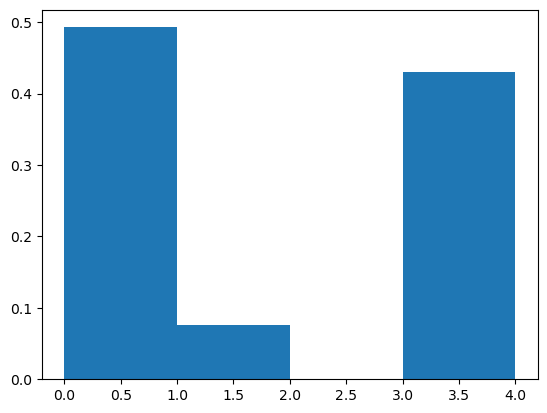

In [5]:
# Primero trabajamos con el TARGET 

# Clases unicas

classes = np.unique(y_train)
nclasses = len(classes)
print(f'classes: {list(classes)}')

# Generamos un encode para cada una de las clases. 

for i in range(0,len(classes)):
    y_train = y_train.replace(f'{list(classes)[i]}', i)
    y_test = y_test.replace(f'{list(classes)[i]}', i)
    
# Generamos un histograma para entender la distribución de las variables target 

plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2), density = True)

# ver value counts 
print(f'value counts: \n{y_train.value_counts()}')

In [6]:
# class weights 

from sklearn.utils import class_weight
import numpy as np

classes = np.unique(y_train)
class_weights_array = class_weight.compute_class_weight('balanced', classes = classes, y = y_train)
class_weights = {classes[i]: class_weights_array[i] for i in range(0, len(classes))}
class_weights

{0: 0.5071416818621342,
 1: 3.2840003502933706,
 2: 953.3898305084746,
 3: 0.5805148263486649}

In [7]:
# onehot encoding target

y_train = keras.utils.to_categorical(y_train, nclasses)
y_test = keras.utils.to_categorical(y_test, nclasses)

In [8]:
# EDA: Ahora empezamos a trabajar con X

pd.set_option('display.float_format',lambda x:'%.3f'% x) #remove scientific notation

X_train.describe()

,cont_3,cont_4,disc_5,cont_9
count,900000.000,900000.000,900000.000,900000.000
mean,1650.397,0.045,3.503,0.001
std,2166.996,99.968,1.707,0.999
min,7.920,-446.890,1.000,-5.510
25%,510.240,-67.350,2.000,-0.670
50%,1000.230,0.120,4.000,0.000
75%,1965.460,67.350,5.000,0.670
max,127527.830,514.260,6.000,5.060


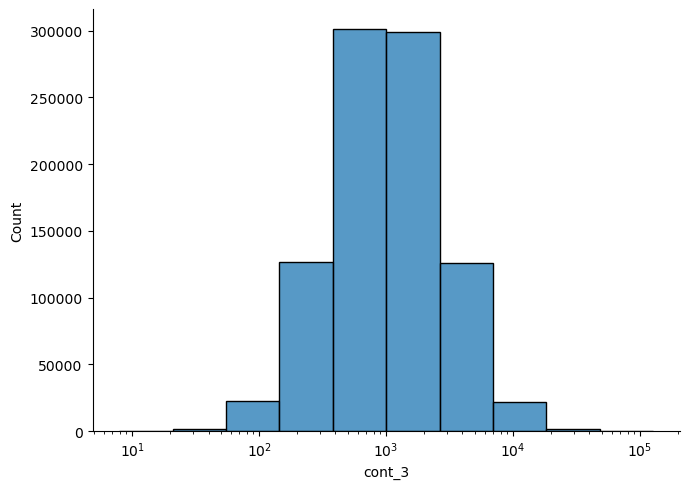

In [9]:
# distribucion 
sns.displot(
  data=X_train,
  x="cont_3",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=10
)

In [10]:
from sklearn.preprocessing import StandardScaler

#Normalization 

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

#scaler

scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features]  = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

/tmp/ipykernel_31040/1981264193.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_features]  = scaler.transform(X_train[numeric_features])
/tmp/ipykernel_31040/1981264193.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = scaler.transform(X_test[numeric_features])


In [11]:
cols_common = [X_train.columns[i] for i in range(len(X_train.columns))]

/tmp/ipykernel_31040/2924969725.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_train[cols_common].corr().round(3),


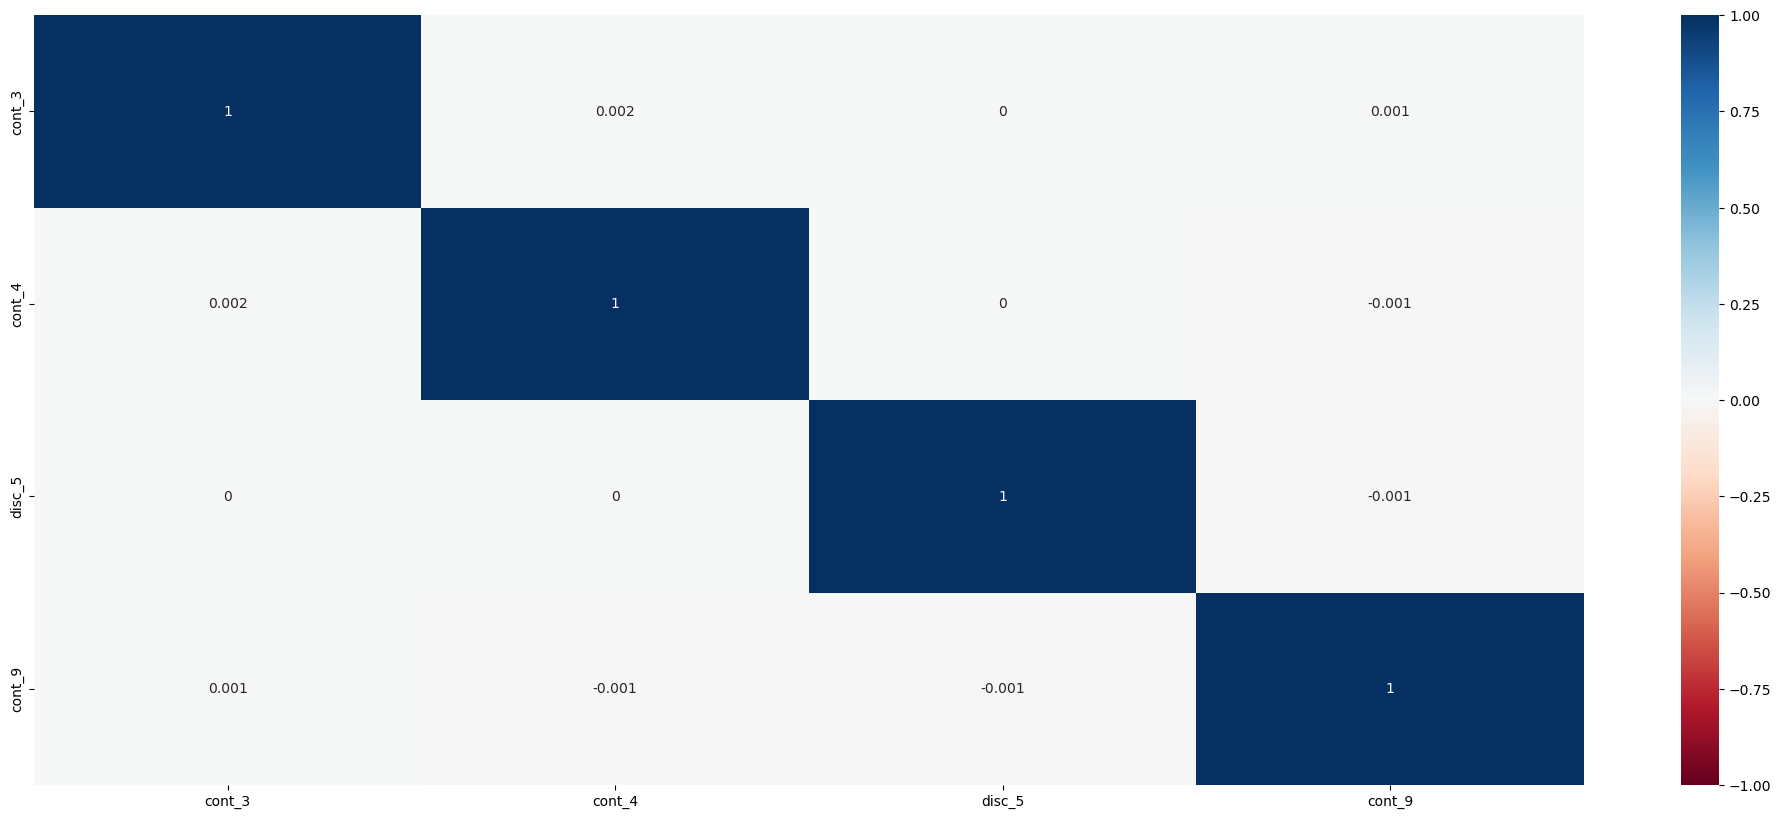

In [12]:
# Feature correlations 

plt.figure(figsize = (25,10))

sns.heatmap(X_train[cols_common].corr().round(3),
            vmin = -1,
            vmax = 1,
            annot = True,
            cmap = 'RdBu')

plt.savefig(f'correlations.jpg')
plt.show()

In [13]:
# Aplicar One-Hot Encoding a las columna 'cat_7' y dropear las de ID + fecha

X_train = pd.get_dummies(X_train, columns=['cat_7'])
X_train = X_train.drop(columns = ['date_2','key_1'])

# Aplicar One-Hot Encoding a las columna 'cat_7' y dropear las de ID + fecha

X_test = pd.get_dummies(X_test, columns=['cat_7'])
X_test = X_test.drop(columns = ['date_2','key_1'])

In [14]:
## Construcción de una NN con arquitectura feedforward sencilla 

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(18, input_shape = (input_dim,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nclasses, activation='softmax'))

2023-02-06 16:05:08.983754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-06 16:05:08.983834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-42-119.us-east-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-02-06 16:05:08.985006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                198       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 76        
                                                                 
Total params: 274
Trainable params: 274
Non-trainable params: 0
_________________________________________________________________


In [16]:
#!pip install tensorflow_addons

In [17]:
import tensorflow_addons as tfa

#Definición de:
# - Hiperparametros de entrenamiento (Learning Rate, Loss Function, Optimizer, Batch Size, Epochs)
# - Métrica objetivo

learn_rate = .001
loss = 'categorical_crossentropy'
opt = Adam(learning_rate= learn_rate)

model.compile(optimizer= opt,loss = loss, metrics = [tf.metrics.Recall(thresholds=0.2)]) #tfa.metrics.F1Score(4, average='weighted',threshold=0.3)])

In [18]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

batch_size = 64
epochs = 20
VERBOSE = 1

training_history = model.fit(X_train.astype('float32'),
                             y_train,
                             validation_data = (X_test.astype('float32'),y_test),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks=[early_stopping],
                             class_weight = class_weights,
                             verbose = VERBOSE)

Epoch 1/20
14063/14063 [==============================] - 30s 2ms/step - loss: 1.5446 - recall: 0.8676 - val_loss: 1.4206 - val_recall: 0.9990
Epoch 2/20
14063/14063 [==============================] - 128s 9ms/step - loss: 1.4253 - recall: 0.9528 - val_loss: 1.4145 - val_recall: 0.9998
Epoch 3/20
14063/14063 [==============================] - 152s 11ms/step - loss: 1.4199 - recall: 0.9418 - val_loss: 1.4479 - val_recall: 0.9849
Epoch 4/20
14063/14063 [==============================] - 28s 2ms/step - loss: 1.4339 - recall: 0.9488 - val_loss: 1.4268 - val_recall: 0.9947
Epoch 5/20
14063/14063 [==============================] - 215s 15ms/step - loss: 1.4308 - recall: 0.9032 - val_loss: 1.3508 - val_recall: 0.9997
Epoch 6/20
14063/14063 [==============================] - 67s 5ms/step - loss: 1.4250 - recall: 0.9510 - val_loss: 1.3412 - val_recall: 0.9998
Epoch 7/20
14063/14063 [==============================] - 63s 4ms/step - loss: 1.4203 - recall: 0.9463 - val_loss: 1.5298 - val_recall: 0

In [19]:
#Validate with test 

y_pseudo_probabilities = model.predict(X_test.astype('float32'))
y_pred = np.argmax(y_pseudo_probabilities)
y_test_max = np.argmax(y_test)


3125/3125 [==============================] - 33s 10ms/step


In [20]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Recall
    ax[1].plot(training.history['recall'], label="recall")
    ax[1].plot(training.history['val_recall'], label="Validation recall")
    ax[1].set_title('%s: recall' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('recall')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

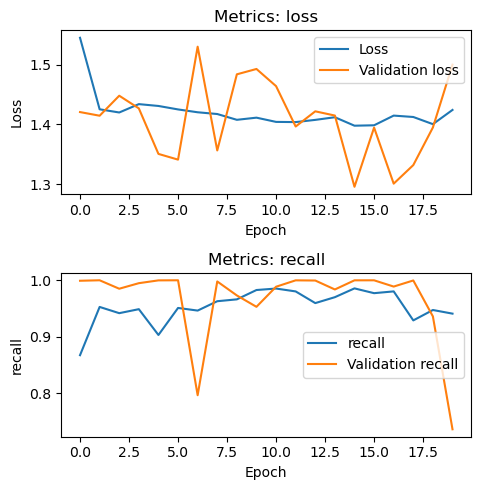

In [21]:
eval_model(training_history, model, y_pred, y_test_max, 'Metrics')

In [22]:
# Model evaluation

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [23]:
# Print metrics
print("Classification report")

test_pred = model.predict(X_test.astype('float32'))

test_pred = np.argmax(test_pred, axis=1)
test_truth = np.argmax(y_test, axis=1)

print(metrics.classification_report(test_truth, test_pred))

Classification report
3125/3125 [==============================] - 32s 10ms/step
              precision    recall  f1-score   support

           0       0.49      0.14      0.22     49277
           1       0.08      0.05      0.06      7506
           2       0.00      0.65      0.00        31
           3       0.43      0.07      0.12     43186

    accuracy                           0.11    100000
   macro avg       0.25      0.23      0.10    100000
weighted avg       0.43      0.11      0.17    100000



In [24]:
#Tuning Hyperparameters

In [50]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

loss = 'categorical_crossentropy'

def create_model(optimizer='adam'):

    # create model
    model = Sequential(name = "Zenpli")
    model.add(Dense(18, input_shape = (input_dim,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nclasses, activation='softmax'))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.Recall(thresholds=0.2)])
    return model

In [51]:
model_grid = KerasClassifier(build_fn=create_model)

/tmp/ipykernel_31040/2475390112.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_grid = KerasClassifier(build_fn=create_model)


In [52]:
from sklearn.model_selection import GridSearchCV

params = {
    'batch_size':  [200],
    'epochs': [30],
    'optimizer':['adam']
}


recall_scorer = make_scorer(recall_score, greater_is_better=True)

grid = GridSearchCV(model_grid,params, scoring=recall_scorer, cv=5)

In [53]:
model_grid = grid.fit(X_train.astype('float32'),y_train)

Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9309 - recall_1: 0.9211
Epoch 2/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9105 - recall_1: 0.9238
Epoch 3/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9099 - recall_1: 0.9238
Epoch 4/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9097 - recall_1: 0.9238
Epoch 5/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9096 - recall_1: 0.9238
Epoch 6/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9096 - recall_1: 0.9238
Epoch 7/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9095 - recall_1: 0.9238
Epoch 8/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9095 - recall_1: 0.9238
Epoch 9/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9095 - recall_1: 0.9238
Epoch 10/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.909

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/ec

Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9894 - recall_2: 0.9036
Epoch 2/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9119 - recall_2: 0.9235
Epoch 3/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9108 - recall_2: 0.9235
Epoch 4/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9104 - recall_2: 0.9235
Epoch 5/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9103 - recall_2: 0.9235
Epoch 6/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9102 - recall_2: 0.9235
Epoch 7/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9102 - recall_2: 0.9235
Epoch 8/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9102 - recall_2: 0.9235
Epoch 9/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9101 - recall_2: 0.9235
Epoch 10/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.910

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/ec

Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9348 - recall_3: 0.9169
Epoch 2/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9109 - recall_3: 0.9236
Epoch 3/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9104 - recall_3: 0.9236
Epoch 4/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9102 - recall_3: 0.9236
Epoch 5/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9101 - recall_3: 0.9236
Epoch 6/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9101 - recall_3: 0.9236
Epoch 7/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9100 - recall_3: 0.9236
Epoch 8/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9100 - recall_3: 0.9236
Epoch 9/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9100 - recall_3: 0.9236
Epoch 10/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.909

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/ec

Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9562 - recall_4: 0.9077
Epoch 2/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9117 - recall_4: 0.9234
Epoch 3/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9108 - recall_4: 0.9234
Epoch 4/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9106 - recall_4: 0.9234
Epoch 5/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9105 - recall_4: 0.9234
Epoch 6/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9104 - recall_4: 0.9234
Epoch 7/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9104 - recall_4: 0.9234
Epoch 8/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9103 - recall_4: 0.9234
Epoch 9/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9103 - recall_4: 0.9234
Epoch 10/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.910

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/ec

Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9368 - recall_5: 0.9157
Epoch 2/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9108 - recall_5: 0.9237
Epoch 3/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9103 - recall_5: 0.9237
Epoch 4/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9100 - recall_5: 0.9237
Epoch 5/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9100 - recall_5: 0.9237
Epoch 6/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9099 - recall_5: 0.9237
Epoch 7/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9098 - recall_5: 0.9237
Epoch 8/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.9098 - recall_5: 0.9237
Epoch 9/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.9098 - recall_5: 0.9237
Epoch 10/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.909

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/ec

Epoch 1/30
4500/4500 [==============================] - 9s 2ms/step - loss: 0.9753 - recall_6: 0.9029
Epoch 2/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9109 - recall_6: 0.9236
Epoch 3/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9103 - recall_6: 0.9236
Epoch 4/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9101 - recall_6: 0.9236
Epoch 5/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9101 - recall_6: 0.9236
Epoch 6/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9100 - recall_6: 0.9236
Epoch 7/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9100 - recall_6: 0.9236
Epoch 8/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9100 - recall_6: 0.9236
Epoch 9/30
4500/4500 [==============================] - 8s 2ms/step - loss: 0.9099 - recall_6: 0.9236
Epoch 10/30
4500/4500 [==============================] - 7s 2ms/step - loss: 0.909

In [54]:
model_grid.best_params_

{'batch_size': 200, 'epochs': 30, 'optimizer': 'adam'}

In [55]:
model_grid.best_estimator_.model.summary()

Model: "Zenpli"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 18)                198       
                                                                 
 dropout_11 (Dropout)        (None, 18)                0         
                                                                 
 dense_23 (Dense)            (None, 4)                 76        
                                                                 
Total params: 274
Trainable params: 274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit with grid params

#patience = 5 

#training_grid, model_tunned = model_grid.fit(
#                X_train.astype('float32'),
#                y_train, 
#                batch_size = batch_size,
#                epochs = epochs,
#                validation_data_X = X_test.astype('float32'), 
#                validation_data_y = y_test,                                
#                patience = patience,
#                class_weights = class_weights
#                )

In [56]:
from keras.models import load_model

model.save('Zenpli_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')